In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_test_loader

In [3]:
import os 

In [4]:
# import some common libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path

In [5]:
data_dir = Path("../imaterialist-fashion-2020-fgvc7")
train_json_path = os.path.join(data_dir, 'trainFix.json')
test_json_path = os.path.join(data_dir, 'validationFix.json')

In [6]:
train_data_name = 'fashion_train'
#val_data_name = 
test_data_name = 'fashion_test'


register_coco_instances(train_data_name, {}, train_json_path, os.path.join(data_dir, 'train') )
register_coco_instances(test_data_name, {}, test_json_path, os.path.join(data_dir, 'train') )

# Inference & Evaluation using the trained model 

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (train_data_name,)
cfg.DATASETS.TEST = (test_data_name, )
cfg.DATALOADER.NUM_WORKERS = 10   # CPU cores are 36 => around 36*2 -1 
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 46  # only has one class (ballon)

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (test_data_name, )



test_metadata = MetadataCatalog.get(test_data_name)

In [9]:
# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)


# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

[06/07 21:40:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/07 21:40:32 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/trainFix.json takes 15.39 seconds.
WARNING [06/07 21:40:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/07 21:40:34 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/trainFix.json
[06/07 21:40:36 d2.data.build]: Removed 0 images with no usable annotations. 41060 images left.
[06/07 21:40:37 d2.data.build]: Distribution of instances among all 46 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| shirt, blouse | 5535         | top, t-shir.. | 14897        |  sweater   | 1341         |
|   cardigan    | 987          |    jacket     | 7027         |    vest    | 652          |
|     pants     | 11152        |    shorts     | 2504         |   sk

Randomly select several samples to visualize the prediction results. 

In [10]:
from detectron2.utils.visualizer import Visualizer, ColorMode

[06/07 21:40:43 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/validationFix.json takes 1.28 seconds.
WARNING [06/07 21:40:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/07 21:40:43 d2.data.datasets.coco]: Loaded 4563 images in COCO format from ../imaterialist-fashion-2020-fgvc7/validationFix.json
../imaterialist-fashion-2020-fgvc7/train/176ee148cc3d1a5b73ce03a22c791eba.jpg


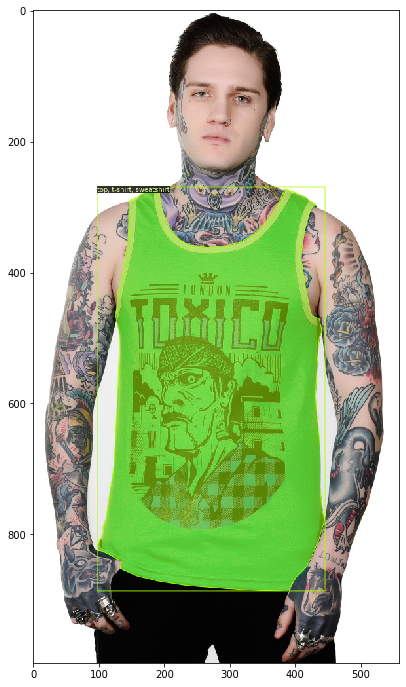

../imaterialist-fashion-2020-fgvc7/train/e4e4e115510e6d9f8ef34f88acc8974d.jpg


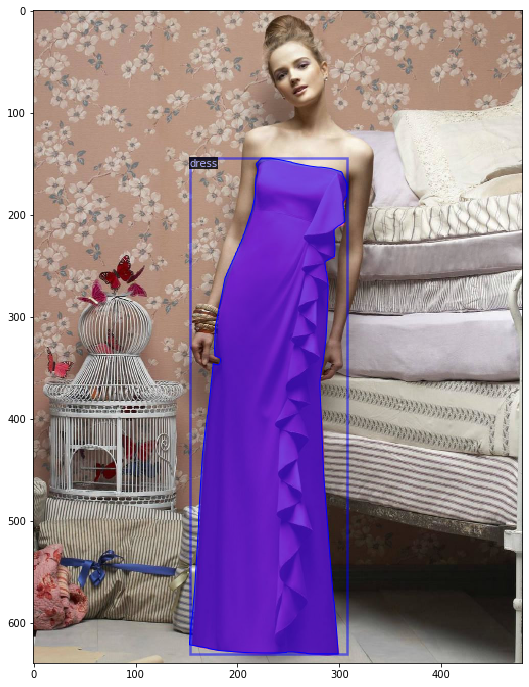

../imaterialist-fashion-2020-fgvc7/train/b158b3c1d9df96335e6ab2a5cd9d761d.jpg


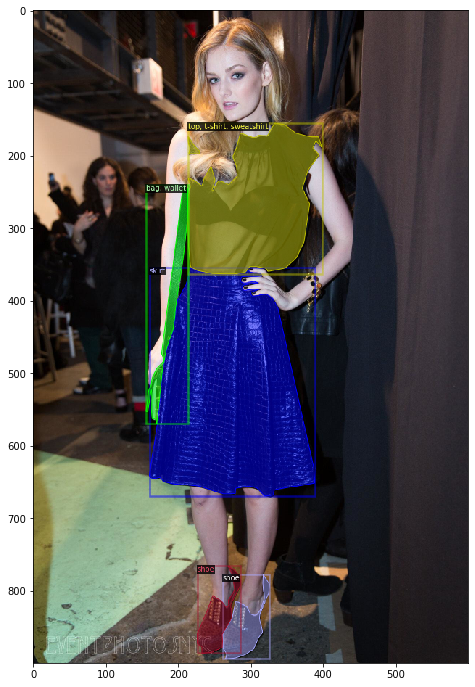

In [11]:
# let's have a look on prediction
test_dataset_dicts = DatasetCatalog.get(test_data_name)

for d in random.sample(test_dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Evaluate its performance using AP metric implemented in COCO API 

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [13]:
evaluator = COCOEvaluator(test_data_name, cfg, False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, test_data_name )

inference_on_dataset(trainer.model, test_loader, evaluator)
# another equivalent way is to use trainer.test

[06/07 21:40:47 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/validationFix.json takes 1.68 seconds.
WARNING [06/07 21:40:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/07 21:40:48 d2.data.datasets.coco]: Loaded 4563 images in COCO format from ../imaterialist-fashion-2020-fgvc7/validationFix.json
[06/07 21:40:48 d2.data.build]: Distribution of instances among all 46 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| shirt, blouse | 626          | top, t-shir.. | 1651         |  sweater   | 153          |
|   cardigan    | 120          |    jacket     | 806          |    vest    | 67           |
|     pants     | 1262         |    shorts     | 252          |   skirt    | 506          |
|     coat      | 342          |     dress     | 1878         | 

[06/07 21:45:27 d2.evaluation.evaluator]: Inference done 3470/4563. 0.0492 s / img. ETA=0:01:27
[06/07 21:45:32 d2.evaluation.evaluator]: Inference done 3545/4563. 0.0492 s / img. ETA=0:01:21
[06/07 21:45:37 d2.evaluation.evaluator]: Inference done 3612/4563. 0.0492 s / img. ETA=0:01:15
[06/07 21:45:43 d2.evaluation.evaluator]: Inference done 3671/4563. 0.0492 s / img. ETA=0:01:11
[06/07 21:45:48 d2.evaluation.evaluator]: Inference done 3755/4563. 0.0492 s / img. ETA=0:01:04
[06/07 21:45:53 d2.evaluation.evaluator]: Inference done 3824/4563. 0.0492 s / img. ETA=0:00:58
[06/07 21:45:58 d2.evaluation.evaluator]: Inference done 3878/4563. 0.0492 s / img. ETA=0:00:54
[06/07 21:46:03 d2.evaluation.evaluator]: Inference done 3949/4563. 0.0492 s / img. ETA=0:00:48
[06/07 21:46:08 d2.evaluation.evaluator]: Inference done 4014/4563. 0.0492 s / img. ETA=0:00:43
[06/07 21:46:13 d2.evaluation.evaluator]: Inference done 4085/4563. 0.0492 s / img. ETA=0:00:37
[06/07 21:46:18 d2.evaluation.evaluator]

OrderedDict([('bbox',
              {'AP': 0.000136002611250136,
               'AP50': 0.0006800130562506801,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 0.00014560279557367502,
               'AP-shirt, blouse': 0.0,
               'AP-top, t-shirt, sweatshirt': 0.0,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 0.0,
               'AP-vest': 0.0,
               'AP-pants': 0.0,
               'AP-shorts': 0.0,
               'AP-skirt': 0.0,
               'AP-coat': 0.0,
               'AP-dress': 0.0,
               'AP-jumpsuit': 0.0,
               'AP-cape': 0.0,
               'AP-glasses': 0.0,
               'AP-hat': 0.0,
               'AP-headband, head covering, hair accessory': 0.0,
               'AP-tie': 0.0,
               'AP-glove': 0.0,
               'AP-watch': 0.0,
               'AP-belt': 0.0,
               'AP-leg warmer': 0.0,
               'AP-